# **Import Database**

In [1]:
import pandas as pd

df = pd.read_csv('/Users/faizralvi/Documents/dataquest25/training_dataset.csv')
test = pd.read_csv('/Users/faizralvi/Documents/dataquest25/validation_set.csv')


# **EDA (Exploratory Data Analysis)**

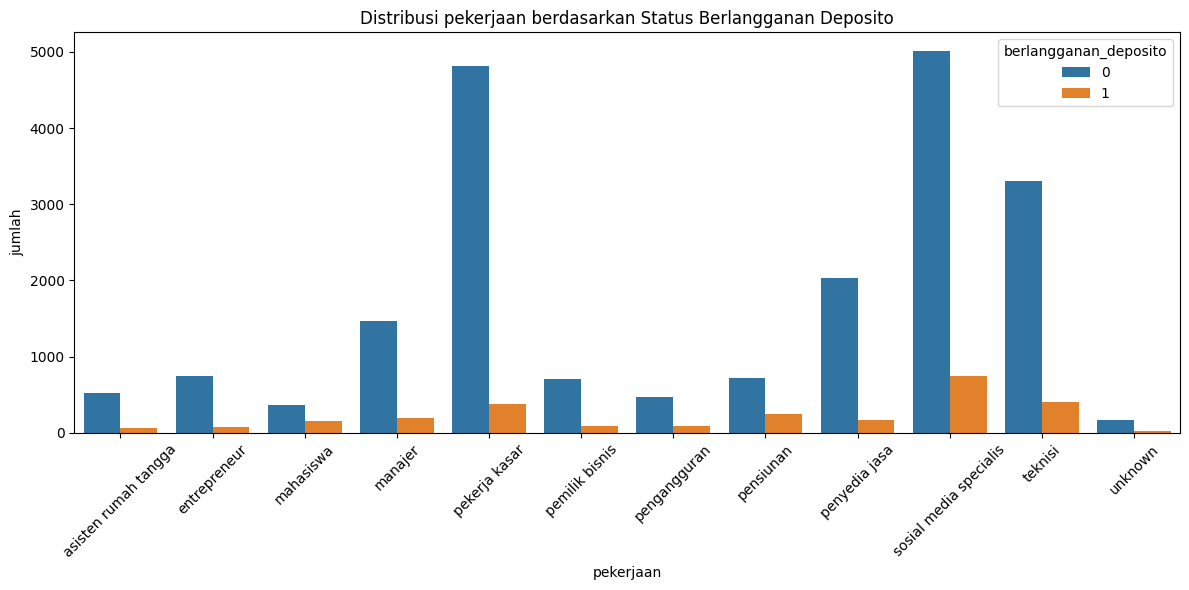

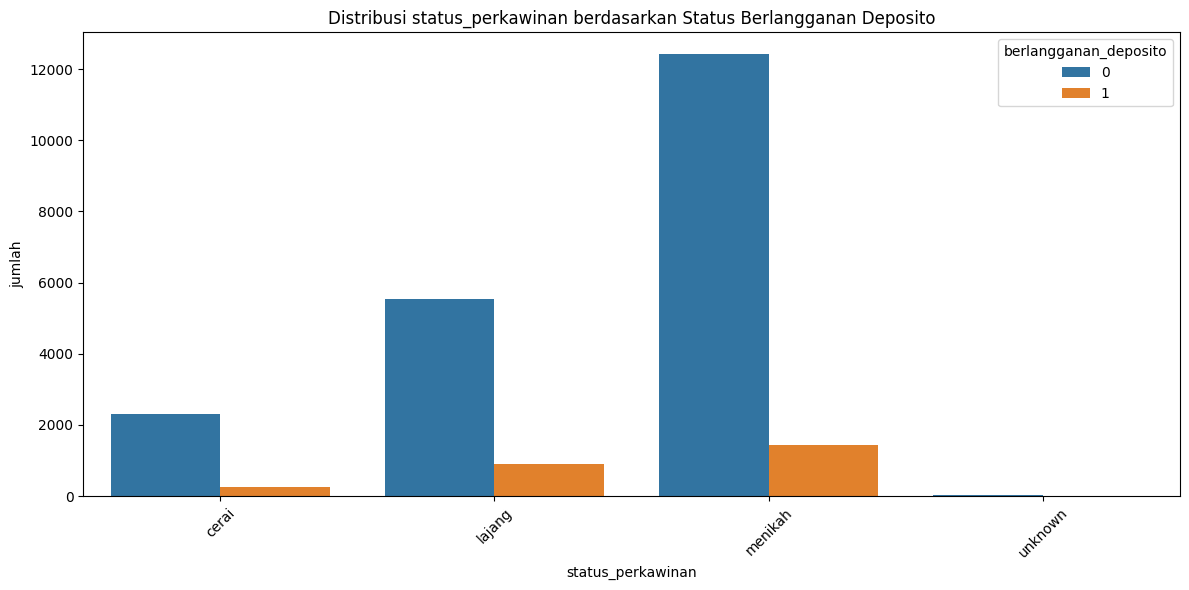

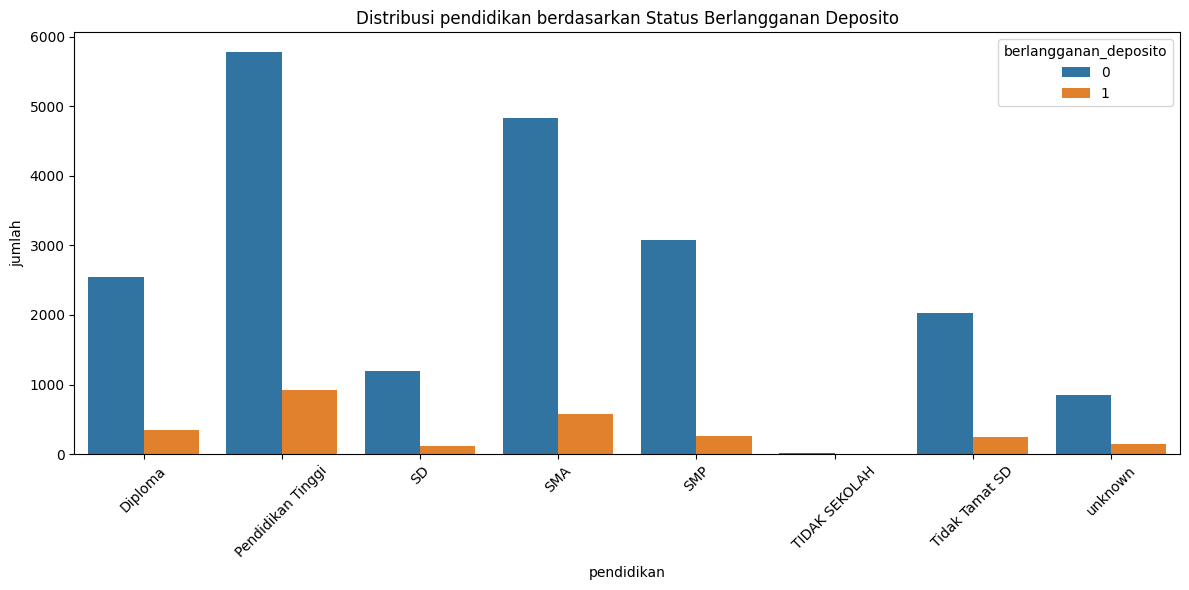

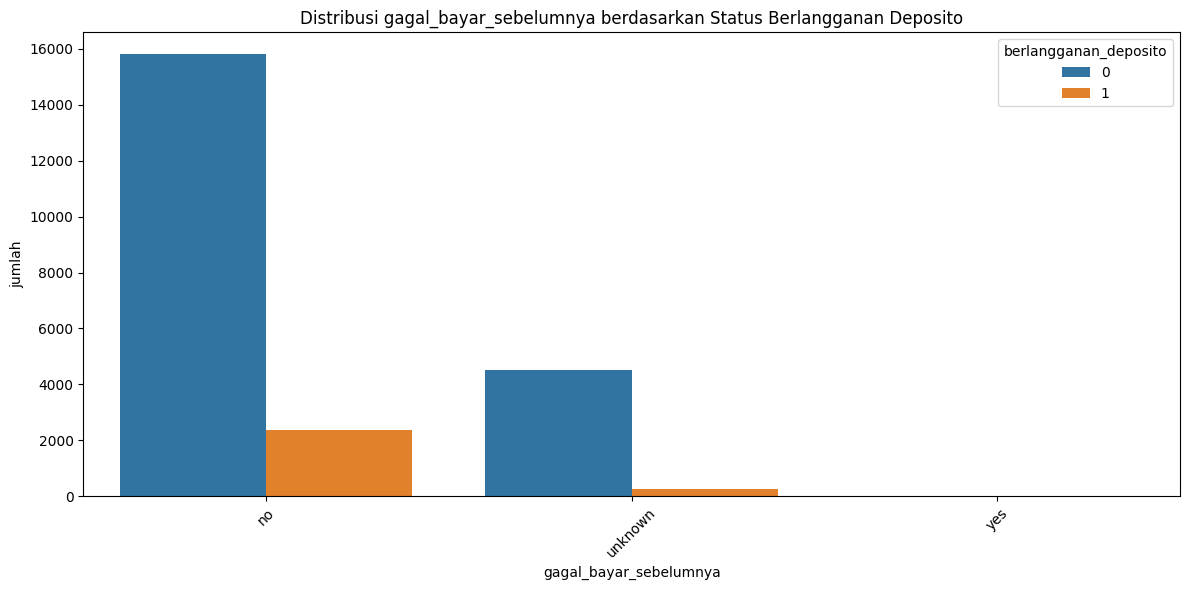

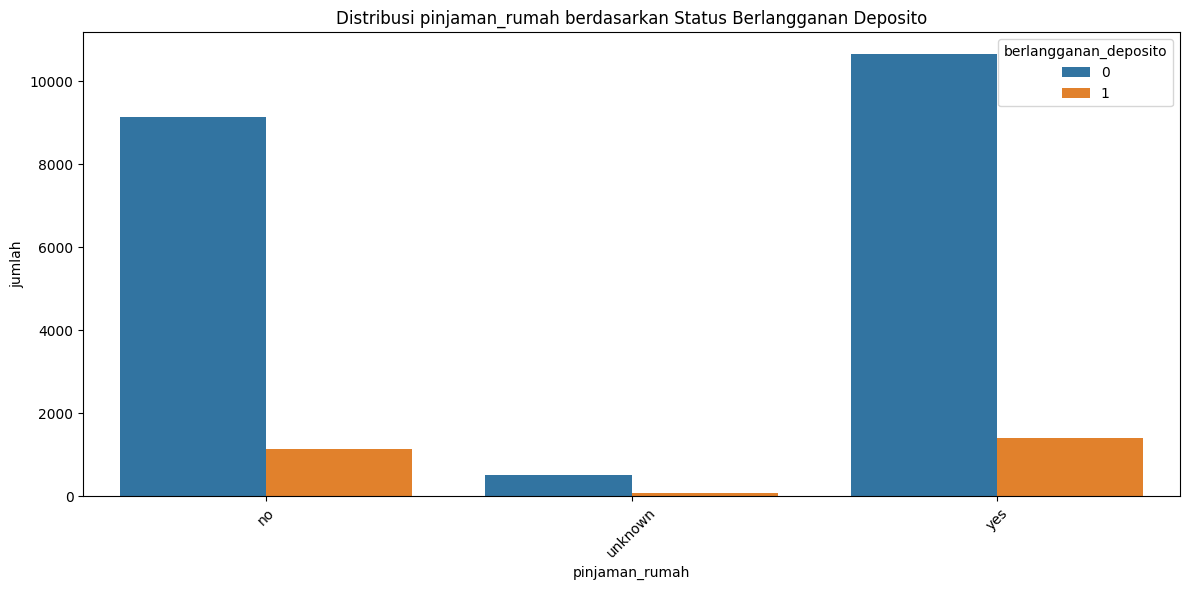

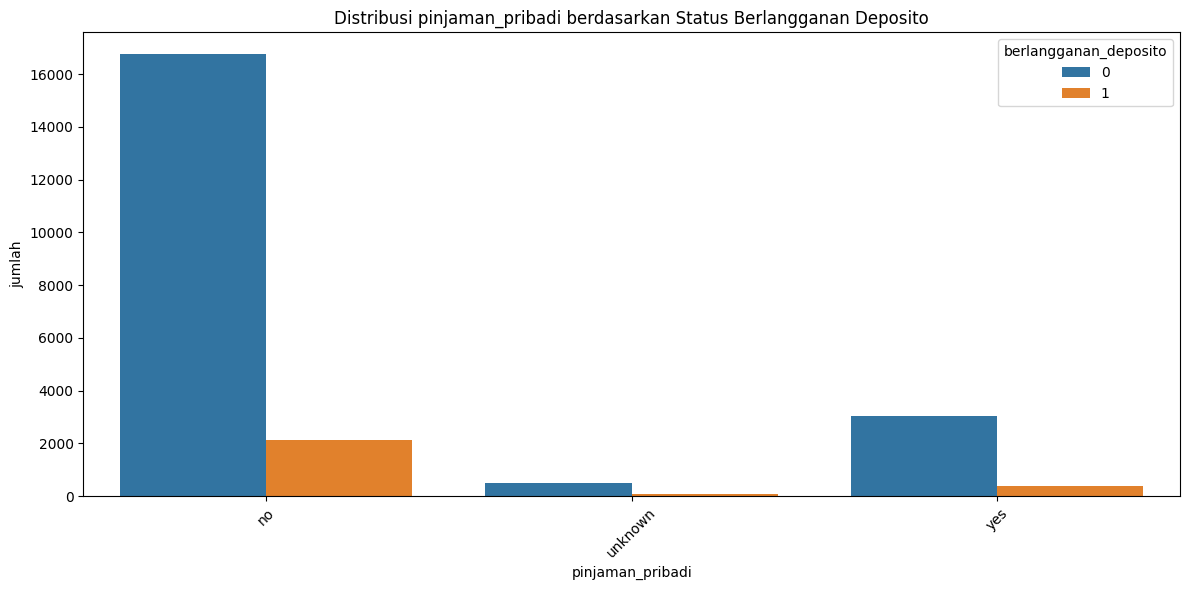

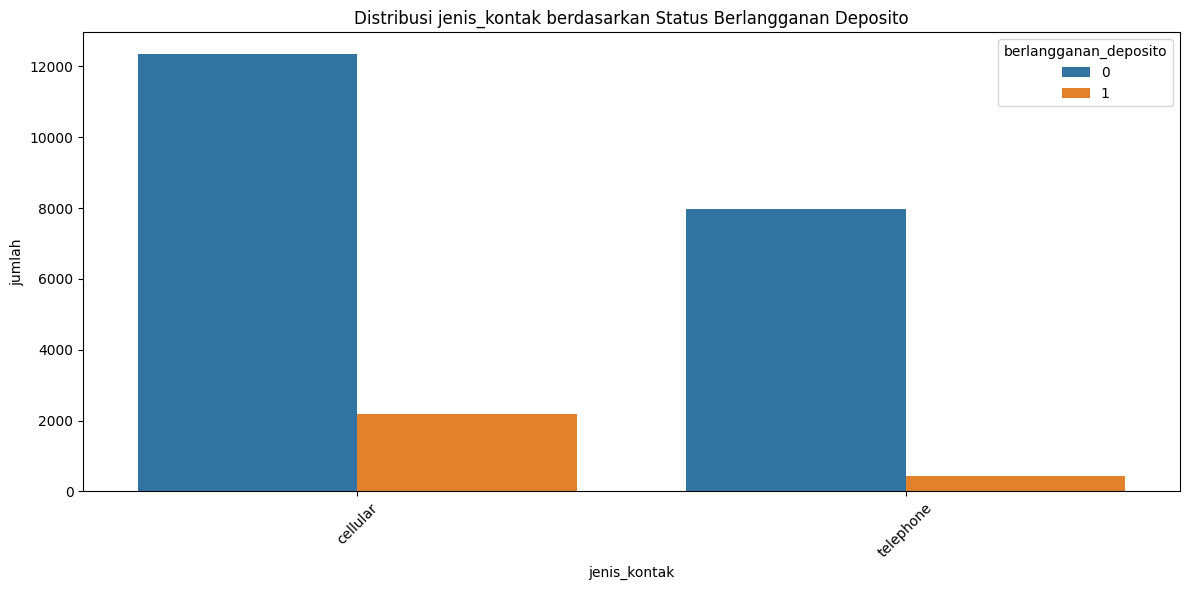

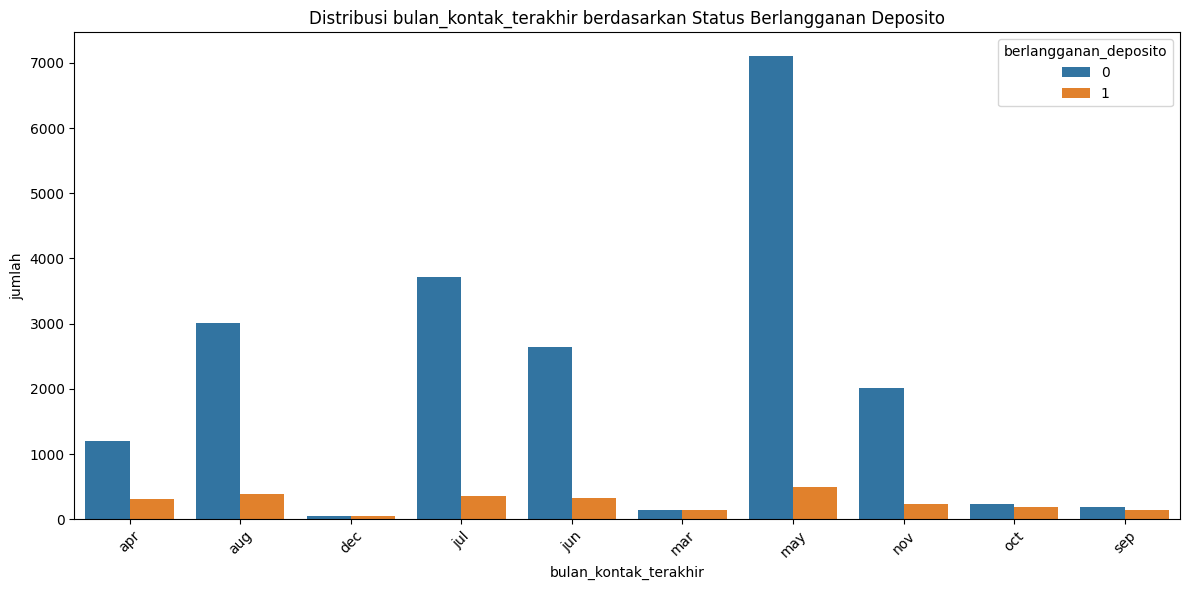

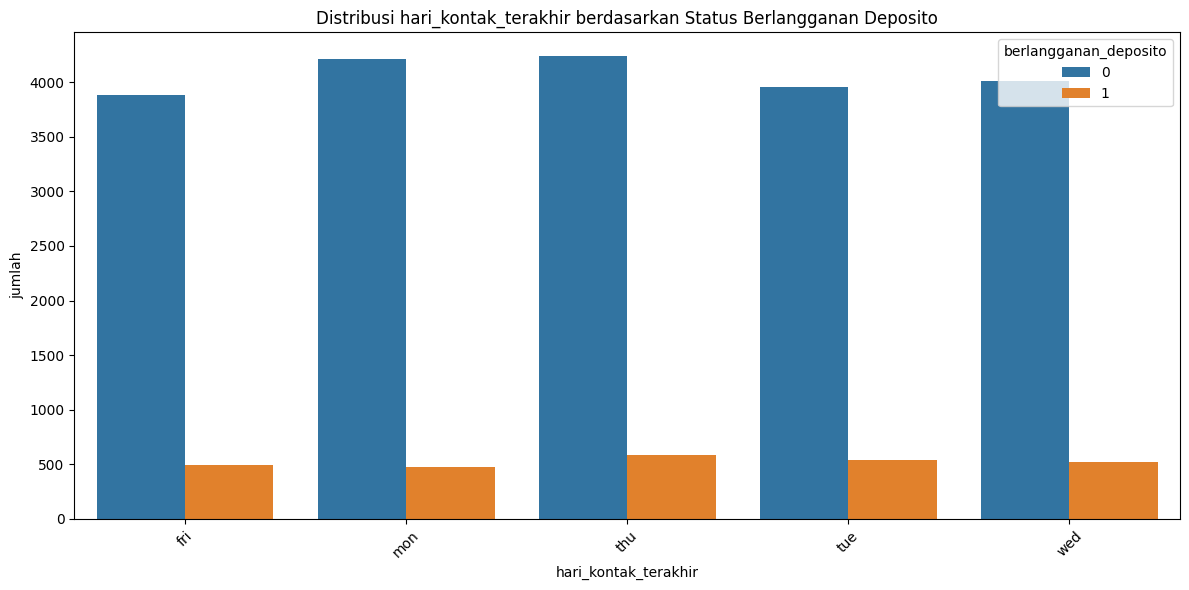

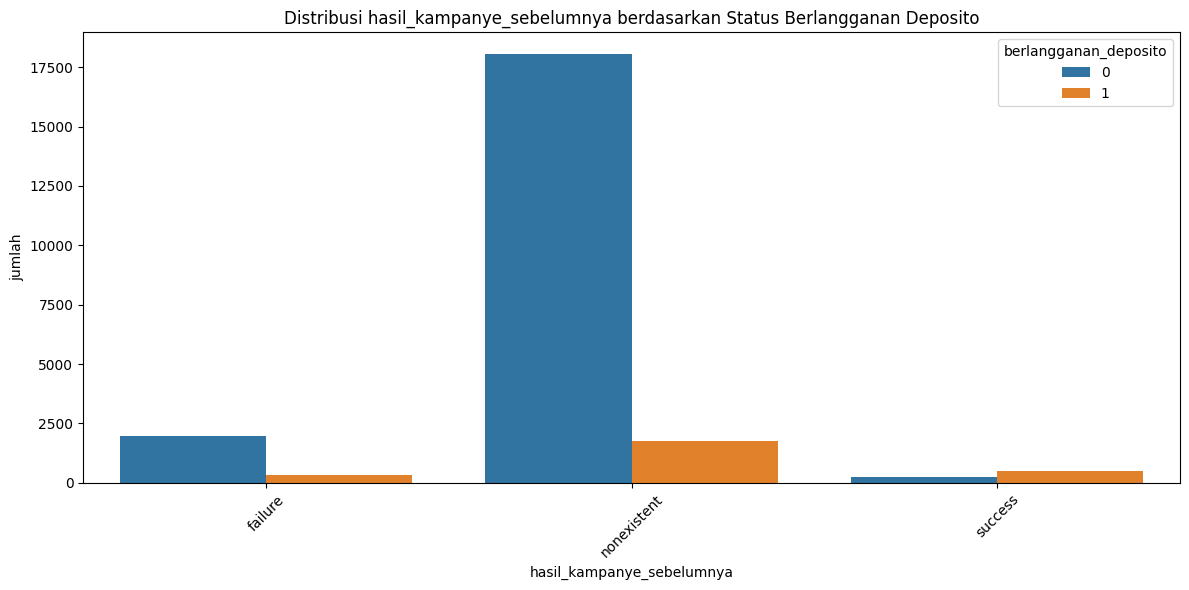

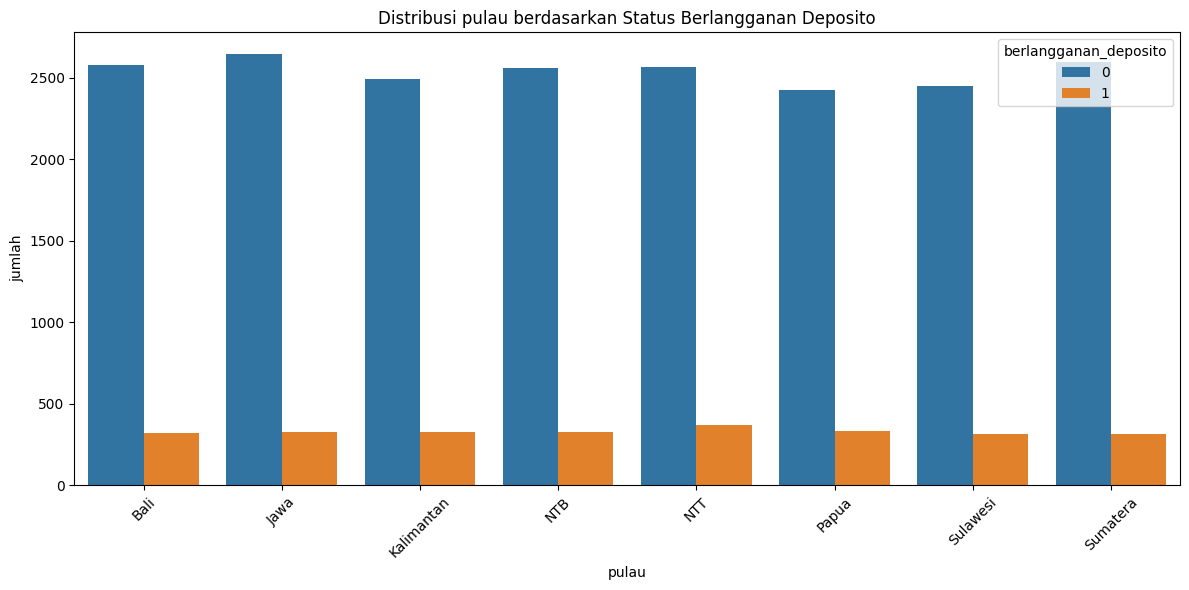

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pilih semua kolom bertipe kategorikal (termasuk object dan category)
kategori_cols = df.select_dtypes(include=['object', 'category']).columns

# Hapus kolom target jika kamu tidak ingin memplot dia terhadap dirinya sendiri
kategori_cols = [col for col in kategori_cols if col != 'berlangganan_deposito']

# Loop untuk membuat visualisasi per kolom kategorikal
for col in kategori_cols:
    plt.figure(figsize=(12, 6))
    counts = df.groupby(['berlangganan_deposito', col]).size().reset_index(name='jumlah')
    sns.barplot(data=counts, x=col, y='jumlah', hue='berlangganan_deposito')
    plt.xticks(rotation=45)
    plt.title(f'Distribusi {col} berdasarkan Status Berlangganan Deposito')
    plt.tight_layout()
    plt.show()


# **Preprocessing**

In [2]:
kategori_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = df.select_dtypes(include=['float', 'int']).columns.tolist()
ordered_cols = numeric_cols + kategori_cols

df = df[ordered_cols]

In [38]:
"""import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import category_encoders as ce

# Inisialisasi encoder
encoder = ce.TargetEncoder(cols=kategori_cols)

# Siapkan DataFrame hasil encoding
df_encoded = df.copy()

# Kolom target
target_col = 'berlangganan_deposito'

# Buat kolom untuk encoded hasil
for col in kategori_cols:
    df_encoded[col + '_te'] = np.nan  # kolom hasil encoding

# K-Fold encoding
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(df, df[target_col]):
    train_fold = df.iloc[train_idx]
    val_fold = df.iloc[val_idx]
    
    # Fit encoder pada train fold
    encoder.fit(train_fold[kategori_cols], train_fold[target_col])
    
    # Transform val fold dan simpan ke df_encoded
    transformed = encoder.transform(val_fold[kategori_cols])
    
    for col in kategori_cols:
        df_encoded.loc[val_fold.index, col + '_te'] = transformed[col]

# Drop kolom original kategorikal (opsional)
df = df_encoded.drop(columns=kategori_cols)

# df_encoded sekarang aman untuk model training
"""

"import pandas as pd\nimport numpy as np\nfrom sklearn.model_selection import StratifiedKFold\nimport category_encoders as ce\n\n# Inisialisasi encoder\nencoder = ce.TargetEncoder(cols=kategori_cols)\n\n# Siapkan DataFrame hasil encoding\ndf_encoded = df.copy()\n\n# Kolom target\ntarget_col = 'berlangganan_deposito'\n\n# Buat kolom untuk encoded hasil\nfor col in kategori_cols:\n    df_encoded[col + '_te'] = np.nan  # kolom hasil encoding\n\n# K-Fold encoding\nkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\nfor train_idx, val_idx in kf.split(df, df[target_col]):\n    train_fold = df.iloc[train_idx]\n    val_fold = df.iloc[val_idx]\n    \n    # Fit encoder pada train fold\n    encoder.fit(train_fold[kategori_cols], train_fold[target_col])\n    \n    # Transform val fold dan simpan ke df_encoded\n    transformed = encoder.transform(val_fold[kategori_cols])\n    \n    for col in kategori_cols:\n        df_encoded.loc[val_fold.index, col + '_te'] = transformed[col]\n\n# 

In [6]:
df['status_perkawinan_pekerjaan'] = df['status_perkawinan']+df['pekerjaan']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_number               22916 non-null  int64  
 1   usia                          22916 non-null  int64  
 2   jumlah_kontak_kampanye_ini    22916 non-null  int64  
 3   hari_sejak_kontak_sebelumnya  22916 non-null  int64  
 4   jumlah_kontak_sebelumnya      22916 non-null  int64  
 5   tingkat_variasi_pekerjaan     22916 non-null  float64
 6   indeks_harga_konsumen         22916 non-null  float64
 7   indeks_kepercayaan_konsumen   22916 non-null  float64
 8   suku_bunga_euribor_3bln       22916 non-null  float64
 9   jumlah_pekerja                22916 non-null  float64
 10  berlangganan_deposito         22916 non-null  int64  
 11  pekerjaan                     22916 non-null  object 
 12  status_perkawinan             22916 non-null  object 
 13  p

# **Train & Evaluate**

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['berlangganan_deposito', 'customer_number'])
y = df['berlangganan_deposito']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [9]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Kolom kategorikal
kategori_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Inisialisasi model
    model = CatBoostClassifier(verbose=0, random_state=42, max_depth=3)

    # Fit model (cat_features harus berupa index kolom)
    model.fit(X_train, y_train, cat_features=[X.columns.get_loc(col) for col in kategori_cols])

    # Predict & score
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)

    print(f"Fold {fold+1} ROC AUC: {auc:.4f}")

print(f"\nMean ROC AUC: {np.mean(auc_scores):.4f}")


Fold 1 ROC AUC: 0.7817
Fold 2 ROC AUC: 0.7995
Fold 3 ROC AUC: 0.8135
Fold 4 ROC AUC: 0.7899
Fold 5 ROC AUC: 0.7954

Mean ROC AUC: 0.7960


In [ ]:
"""from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM (RBF Kernel)': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}
"""

In [ ]:
""""
from sklearn.metrics import roc_auc_score

# Melatih dan evaluasi ROC AUC
for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"{name} ROC AUC: {auc:.4f}")
""""

/Users/faizralvi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression ROC AUC: 0.7653
Random Forest ROC AUC: 0.7937
XGBoost ROC AUC: 0.7663
CatBoost ROC AUC: 0.7837
Gradient Boosting ROC AUC: 0.7951


/Users/faizralvi/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost ROC AUC: 0.7901
Naive Bayes ROC AUC: 0.7746
SVM (RBF Kernel) ROC AUC: 0.7750
K-Nearest Neighbors ROC AUC: 0.7184


In [ ]:
"""from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, recall_score, precision_score,
    f1_score, accuracy_score
)
import numpy as np

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    auc_scores = []
    recall_scores = []
    precision_scores = []
    f1_scores = []
    acc_scores = []

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        auc_scores.append(roc_auc_score(y_test, y_proba))
        recall_scores.append(recall_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        acc_scores.append(accuracy_score(y_test, y_pred))

    print(f"{name}")
    print(f"  ROC AUC      : {np.mean(auc_scores):.4f}")
    print(f"  Accuracy     : {np.mean(acc_scores):.4f}")
    print(f"  Precision    : {np.mean(precision_scores):.4f}")
    print(f"  Recall       : {np.mean(recall_scores):.4f}")
    print(f"  F1 Score     : {np.mean(f1_scores):.4f}")
    print("-" * 40)
"""

/Users/faizralvi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/faizralvi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Logistic Regression ROC AUC (CV Mean): 0.7687
Random Forest ROC AUC (CV Mean): 0.7815
XGBoost ROC AUC (CV Mean): 0.7576
CatBoost ROC AUC (CV Mean): 0.7922
Gradient Boosting ROC AUC (CV Mean): 0.7953


/Users/faizralvi/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/faizralvi/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/faizralvi/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/faizralvi/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

AdaBoost ROC AUC (CV Mean): 0.7890
Naive Bayes ROC AUC (CV Mean): 0.7776
SVM (RBF Kernel) ROC AUC (CV Mean): 0.6867
K-Nearest Neighbors ROC AUC (CV Mean): 0.7217


# **Predict**

In [53]:
from catboost import CatBoostClassifier

# Pisahkan fitur dan target dari df_test
X_final_test = test.drop(columns=['customer_number'])
customer_ids = test['customer_number']

# Pastikan kolom kategori sudah sesuai
kategori_cols_test = X_final_test.select_dtypes(include=['object', 'category']).columns.tolist()

# Inisialisasi dan fit model pada seluruh data latih
final_model = CatBoostClassifier(verbose=0, random_state=42, max_depth=3)
final_model.fit(X, y, cat_features=[X.columns.get_loc(col) for col in kategori_cols])

# Predict proba untuk kelas 1 (berlangganan deposito)
y_final_proba = final_model.predict_proba(X_final_test)[:, 1]

# Buat DataFrame hasil
output_df = pd.DataFrame({
    'customer_number': customer_ids,
    'berlangganan_deposito': y_final_proba
})

# Tampilkan hasil
output_df.head()


,customer_number,berlangganan_deposito
0,445420,0.058403
1,585604,0.032886
2,888824,0.026112
3,816820,0.031539
4,542716,0.055199


In [ ]:
# Simpan ke file CSV
output_df.to_csv("prediksi_berlangganan_deposito.csv", index=False)
